In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=bb2299985082e5f35164d9500cace6af3081580148c364c5901c6774e45a5833
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c severstal-steel-defect-detection

 99% 1.55G/1.57G [00:12<00:00, 146MB/s]
100% 1.57G/1.57G [00:12<00:00, 137MB/s]


In [ ]:
!unzip severstal-steel-defect-detection.zip

# ***Exploratory Data Analysis***

In [ ]:
### Import Libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 101)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16})
from collections import defaultdict
import seaborn as sns
from pathlib import Path
from PIL import Image

In [ ]:
train_df = pd.read_csv("dataset/train.csv")
sample_df = pd.read_csv("dataset/sample_submission.csv")

In [ ]:
train_df.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


In [ ]:
train_df['EncodedPixels'][0]

'29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5'

In [ ]:
values, counts = np.unique(train_df['ClassId'].values, return_counts=True)

Text(0.5, 0, 'Class')

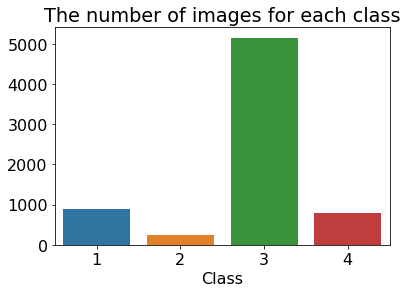

In [ ]:
### Visualize the number of images for each class
fig, ax = plt.subplots()
sns.barplot(x=values, y=counts, ax=ax)
ax.set_title("The number of images for each class")
ax.set_xlabel("Class")

In [ ]:
### Check image data
### image size
train_size_dict = defaultdict(int)
train_path = Path('dataset/train_images/')

for img_name in train_path.iterdir():
  img = Image.open(img_name)
  train_size_dict[img.size] += 1

print('train_size_dict: ', train_size_dict)

train_size_dict:  defaultdict(<class 'int'>, {(1600, 256): 12568})


In [ ]:
test_size_dict = defaultdict(int)
test_path = Path('dataset/test_images/')

for img_name in test_path.iterdir():
  img = Image.open(img_name)
  test_size_dict[img.size] += 1

test_size_dict

defaultdict(int, {(1600, 256): 5506})

## **Visualization Mask**

In [ ]:
img_in_classes = train_df['ImageId'].value_counts()
img_in_classes

ef24da2ba.jpg    3
db4867ee8.jpg    3
16d0b11ff.jpg    2
89158744a.jpg    2
64443519b.jpg    2
                ..
aa2db8e29.jpg    1
9ed47c324.jpg    1
ea2ebb194.jpg    1
3a222ca8a.jpg    1
948f9558f.jpg    1
Name: ImageId, Length: 6666, dtype: int64

In [ ]:
img_in_3_class = [img_in_classes.index[i] for i in range(2)]

In [ ]:
img_in_2_class = [img_in_classes.index[i] for i in range(len(img_in_classes)) if img_in_classes.values[i] == 2]

In [ ]:
def take_name_mask(idx):
  img_name = train_df.iloc[idx]["ImageId"]
  if img_name in img_in_3_class:
    take_indices = train_df.index[train_df["ImageId"] == img_name].tolist()
    cls_ids, labels = train_df.iloc[take_indices]["ClassId"].values ,train_df.iloc[take_indices]["EncodedPixels"].values
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)
    
    for cls_id, label in zip(cls_ids, labels):
      mask_label = np.zeros(1600*256, dtype=np.uint8)
      label = label.split(" ")
      positions = map(int, label[0::2])
      length = map(int, label[1::2])
      for pos, le in zip(positions, length):
        mask_label[pos-1:pos+le-1] = 1
      mask[:, :, cls_id-1] = mask_label.reshape(256, 1600, order="F")
  elif img_name in img_in_2_class:
    take_indices = train_df.index[train_df["ImageId"] == img_name].tolist()
    cls_ids, labels = train_df.iloc[take_indices]["ClassId"].values ,train_df.iloc[take_indices]["EncodedPixels"].values
    # print("cls_ids: ", cls_ids)
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)
    
    for cls_id, label in zip(cls_ids, labels):
      mask_label = np.zeros(1600*256, dtype=np.uint8)
      label = label.split(" ")
      positions = map(int, label[0::2])
      length = map(int, label[1::2])
      for pos, le in zip(positions, length):
        mask_label[pos-1:pos+le-1] = 1
      mask[:, :, cls_id-1] = mask_label.reshape(256, 1600, order="F")
  else:
    take_indices = train_df.index[train_df["ImageId"] == img_name].tolist()
    cls_ids, labels = train_df.iloc[take_indices]["ClassId"].values,train_df.iloc[take_indices]["EncodedPixels"].values
    # print("cls_ids 1 class: ", cls_ids)
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)
    
    for cls_id, label in zip(cls_ids, labels):
      mask_label = np.zeros(1600*256, dtype=np.uint8)
      label = label.split(" ")
      positions = map(int, label[0::2])
      length = map(int, label[1::2])
      for pos, le in zip(positions, length):
        mask_label[pos-1:pos+le-1] = 1
      mask[:, :, cls_id-1] = mask_label.reshape(256, 1600, order="F") 
  return img_name, mask, cls_ids

In [ ]:
def show_mask_image(idx):
  name, mask, cls_ids = take_name_mask(idx)
  img = cv2.imread(str(train_path / name))
  fig, ax = plt.subplots(figsize=(15,15))
  # print("cls_ids: ", cls_ids)
  
  for cls_id in cls_ids:
    # print("cls_id: ", cls_id)
    contours, _ = cv2.findContours(mask[:, :, cls_id-1], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(0, len(contours)):
      # print("len(contours): ", len(contours))
      cv2.polylines(img, contours[i], True, color=palet[cls_id-1], thickness=2)
    # print("len(contours): ", len(contours))
  ax.set_title(name)
  ax.imshow(img)
  plt.show()

In [ ]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

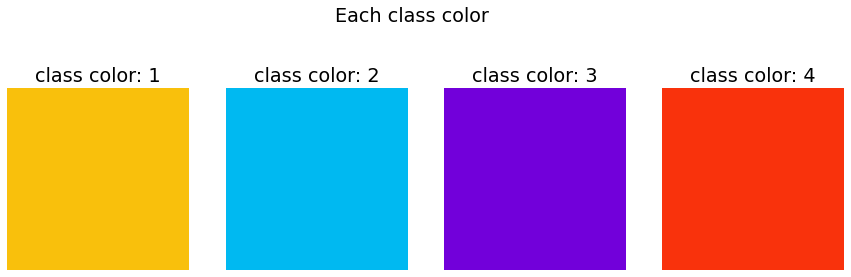

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
  ax[i].axis('off')
  ax[i].imshow(np.ones((50,50,3), dtype=np.uint8) * palet[i])
  ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("Each class color")
plt.show()

In [ ]:
# train_df["ImageId"]
idx_list = []
count_3 = 0
count_2 = 0
for idx, value in zip(train_df["ImageId"].index, train_df["ImageId"].values):
  if value in img_in_3_class:
    if count_3 == 1:
      count_3 += 1
      continue
    elif count_3 ==2:
      count_3 = 0
      continue
    print(value)
    print(count_3)
    idx_list.append(idx)
    count_3 = count_3 + 1
    
  
  elif value in img_in_2_class:
    if count_2 > 0:
      count_2 = 0
      continue
    idx_list.append(idx)
    count_2 += 1
  else:
    idx_list.append(idx)

In [ ]:
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for idx in idx_list:
  if train_df.iloc[idx]["ImageId"] in img_in_3_class:
    idx_class_triple.append(idx)
  elif train_df.iloc[idx]["ImageId"] in img_in_2_class:
    idx_class_multi.append(idx)
  else:
    cls = train_df.iloc[idx]["ClassId"]
    if cls == 1:
      idx_class_1.append(idx)
    elif cls == 2:
      idx_class_2.append(idx)
    elif cls == 3:
      idx_class_3.append(idx)
    elif cls == 4:
      idx_class_4.append(idx)

    

# **Images in class 1**

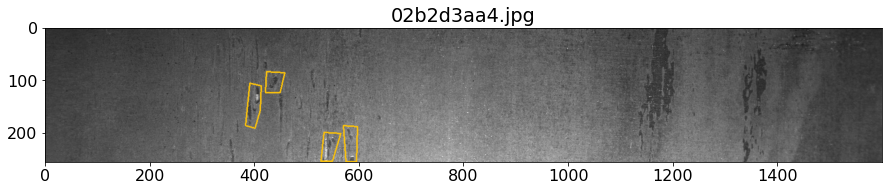

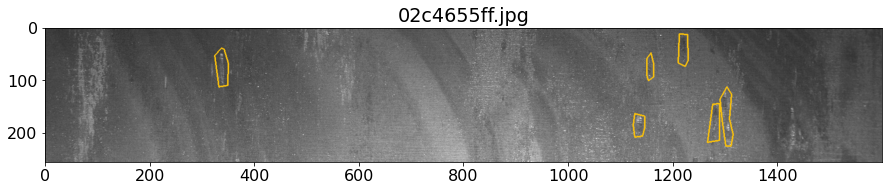

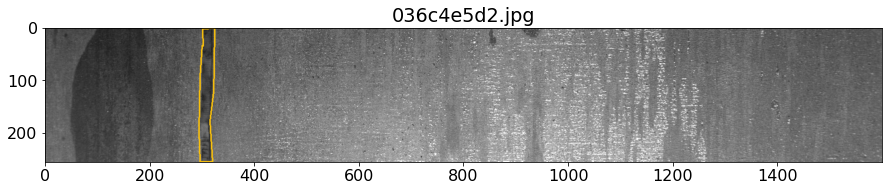

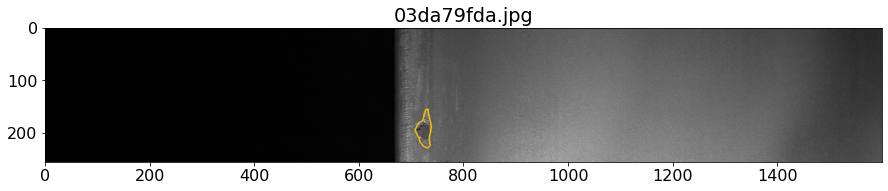

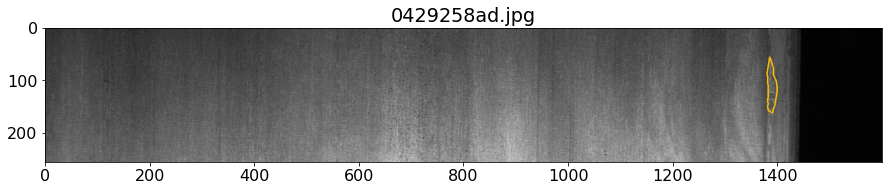

In [ ]:
for idx in idx_class_1[10:15]:
  show_mask_image(idx)

# **Images in class 2**

cls_ids:  [2]


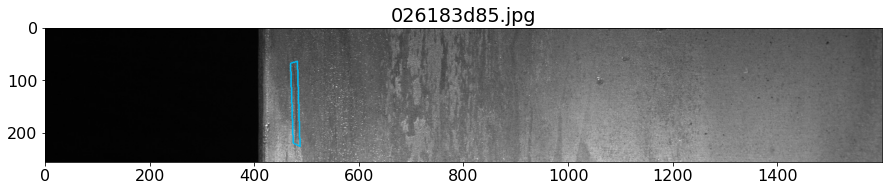

cls_ids:  [2]


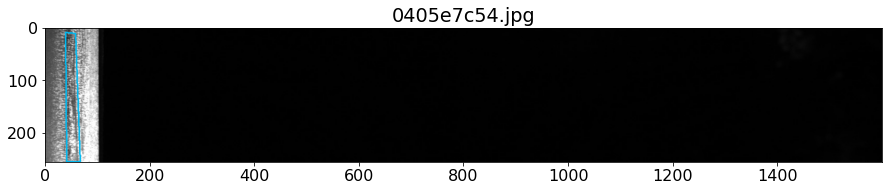

cls_ids:  [2]


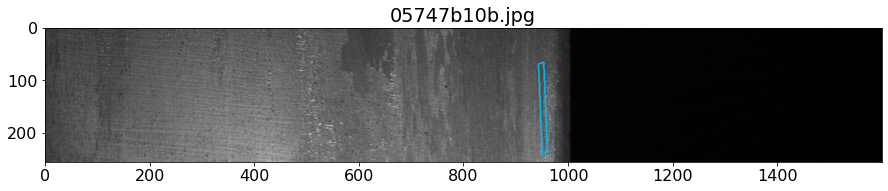

cls_ids:  [2]


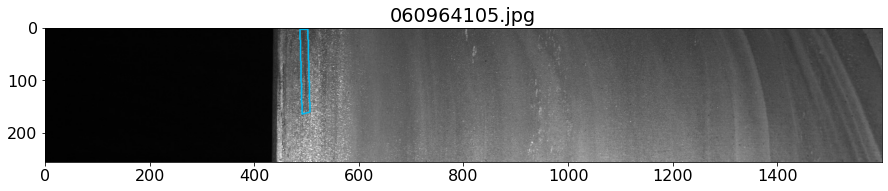

cls_ids:  [2]


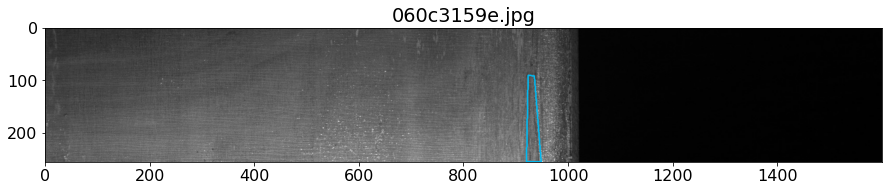

In [ ]:
for idx in idx_class_2[:5]:
  show_mask_image(idx)

# **Images in class 3**

cls_ids:  [3]


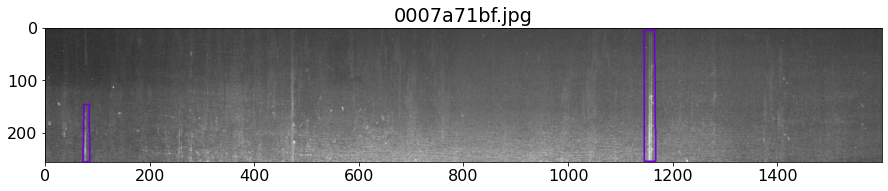

cls_ids:  [3]


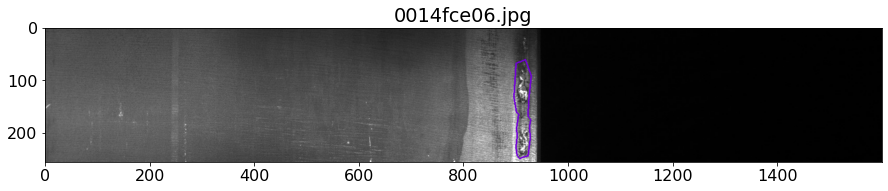

cls_ids:  [3]


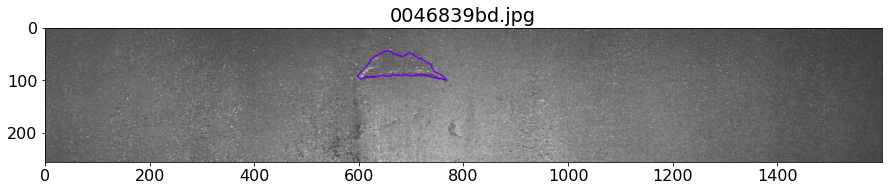

cls_ids:  [3]


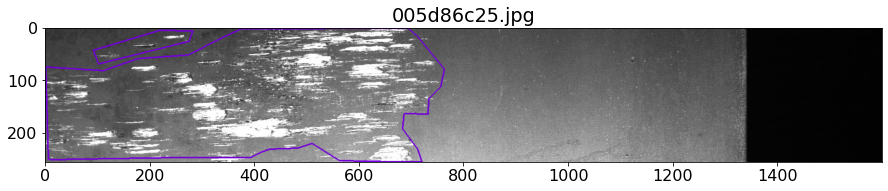

cls_ids:  [3]


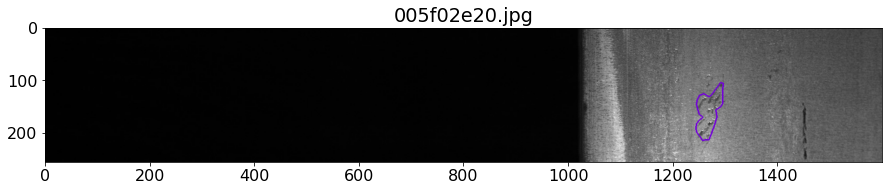

In [ ]:
for idx in  idx_class_3[:5]:
  show_mask_image(idx)

# **Images in class 4**

cls_ids:  [4]


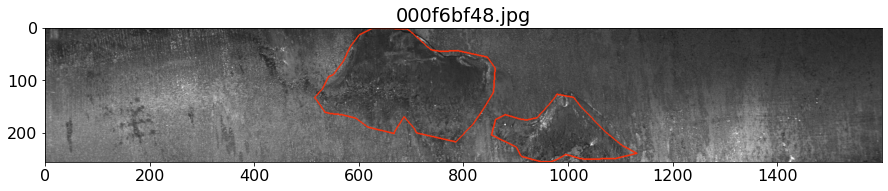

cls_ids:  [4]


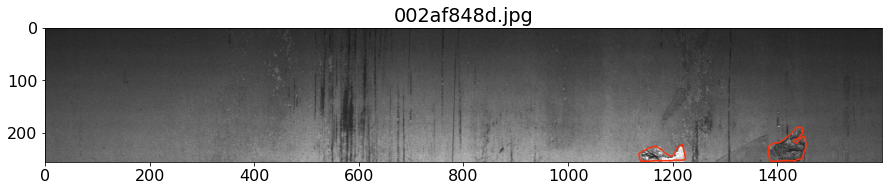

cls_ids:  [4]


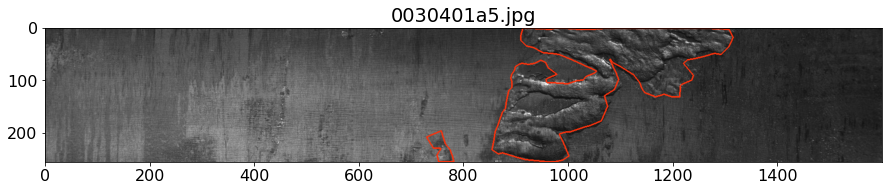

cls_ids:  [4]


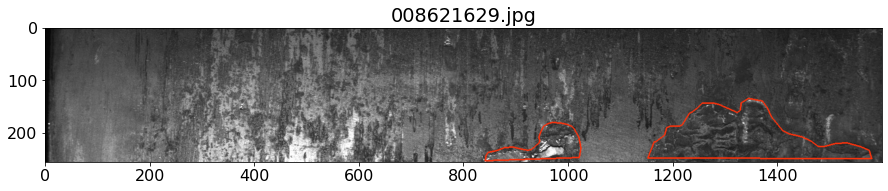

cls_ids:  [4]


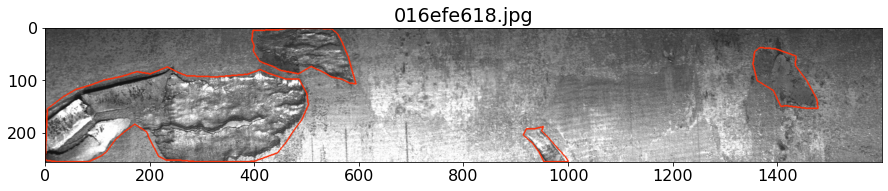

In [ ]:
for idx in idx_class_4[:5]:
  show_mask_image(idx)

## **Images with multiple classes**

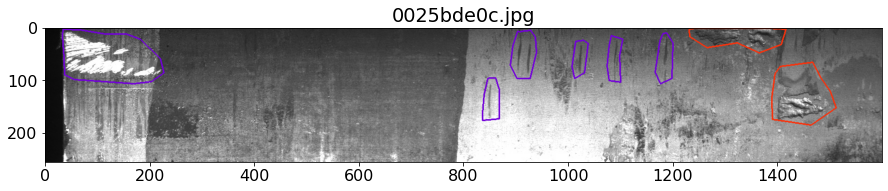

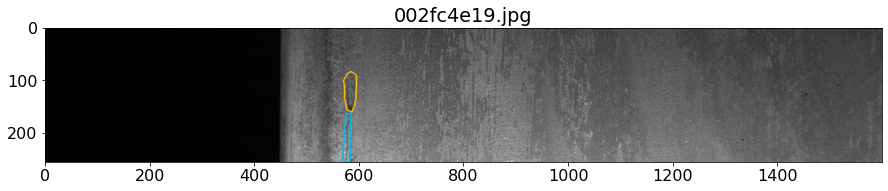

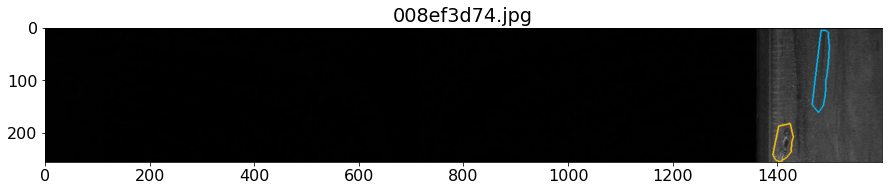

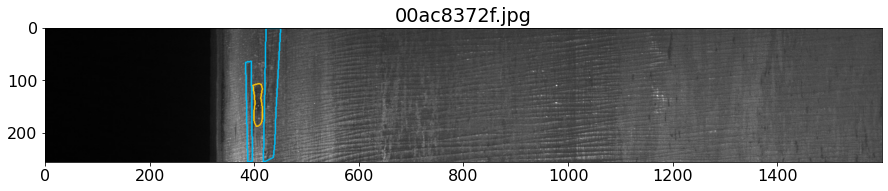

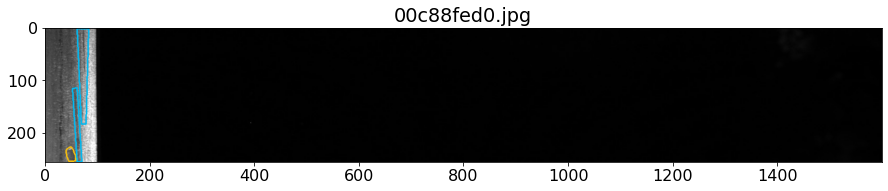

In [ ]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)

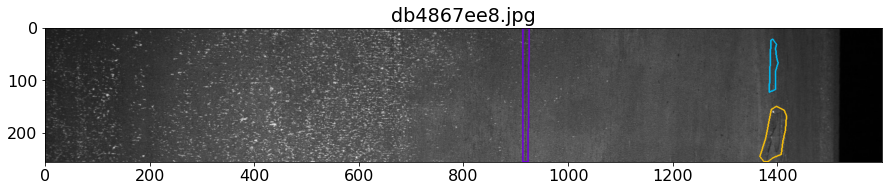

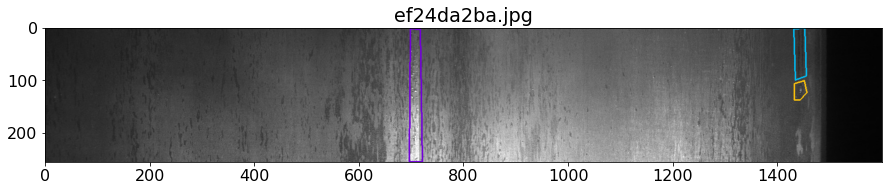

In [ ]:
for idx in idx_class_triple[:5]:
    show_mask_image(idx)